# Bayesian Framework in A/B Testing
In this notebook we will discuss using a bayesian framework in A/B testing. We will also compare and contrast with the more often used frequentist framework in A/B testing

# What is A/B Testing?

The tech world's nomenclature for "randomized control trial". A quick example which we will use throughout the rest of this notebook is Clover's medication adherence intervention (one of our first experiments truly run in the field). **In this notebook we will discuss a very simplified view of this experiment with fake results**. Don't focus too much on the actual numbers, just the concept.

1. The "A" group is traditionally considered as the control. In this example, suppose we put many members into the "A" group and do not carry out any intervention.
2. The "B" group is traditionally the intervention group. In this example, suppose the intervention is a phone call reminding the member to pick up their medication.

The idea is we randomly split a subset of members into A and B group and test the effect of our intervention (a phone call) on medication fill rates. 

# The Frequentist Perspective

The frequentist framework in evaluating A/B tests generally
1. does not take into account prior information; comparisons between the A and B group rely solely on the data from the experiment with no incorporation of prior beliefs.
2. does not view results as probability distribution. In other words, in this example, we want to compare the fill rate between the two groups. A frequentist would generally view the fill rate as unknown, but fixed. 

Generally an A/B test done with a frequentist perspective would look like the following:
1. Perform some kind of power calculation to calculate the required sample size in advance. The power calculation will depend on $\alpha$, $\beta$, and the effect size you want to detect. 
2. Randomly split into A/B groups and apply intervention to B group.
3. Launch the test and let it run until the required sample size is reached (without peaking at the data, or at least not acting on peaking at the data).
4. Analyze results! In the frequentist world, this normally involves calculating some p-value comparing the fill rates between the two groups. The general interpretation of said p-value would be "assuming that there is actually no difference between the A and B group, what is the probability we would see a difference in fill rate at least as extreme as we observed".
    

# The Bayesian Perspective

The main differentiating factor between the bayesian perspective vs the frequentist perspective is that in a bayesian world, we view results as a probability distribution of the outcome of interest, as opposed to a fixed number. In addition, a bayesian framework gives us a natural way to incorporate prior distributions.

In the example of using an A/B test to evaluate the effect of a call campaign on medication fill rates, in a strict frequentist view, the framework would be that we're estimating the "true" fill rate in each group with a fixed number. In a bayesian view, we estimate the fill rate as a probability distribution given some prior (that we need to define) and updating that prior with the experiment results.

How an A/B test is conducted from a Bayesian perspective is still largely the same. The main difference will be in how we actually analyze the results. In particular, "p-value" is not a term that exists in Bayesian world, so how do we compare groups A and B? What is the result that is returned and how do we interpret it? These are best dealt with using an example.

Let's assume that there are 300 members that would qualify for a call campaign on medication fill rates. We're only going to be running our test on 150 of these members, with 150 remaining as control. Group A will receive whatever normal interventions from Clover. Group B will as well, but now in addition, members in group B also receive a phone call to remind them to pick up their medication.

Next we need to figure out what prior probability we are going to use. This is one of the tougher parts about using a Bayesian framework (more on that below). Let's say we have a reasonable expectation that the probability of the member filling their prescription should be around 30%. To make things simple we'll use the same prior for A and B. We'll also choose a pretty weak version of our prior for illustrative purposes -- we'll settle on Beta(3,7):

In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
%matplotlib inline

from bayesian_analysis.em_upcoding import beta_binomial as bb

In [2]:
distribution_values = bb.beta_values(alpha=3, beta=7)

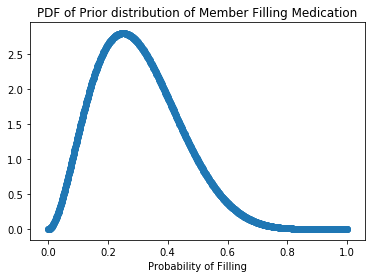

In [3]:
plt.scatter(distribution_values[0], distribution_values[1])
plt.xlabel('Probability of Filling')
plt.title('PDF of Prior distribution of Member Filling Medication')
plt.show()

Now, let's say we actually run the experiment and get these results:

| Group|Fill   	|Not Fill |	
|-------|------|------|
|Group A   	|36   	|114	|
|Group B   	|50  	|100 |

In a different notebook, we discuss the update rules using the beta-binomial distribution. We won't go through that again here, but it turns out that using the experiment results, we update our prior to obtain the posterior distributions for the fill rate of Group A vs Group B as
$$Beta(3 + 36, 7 + 114)$$
$$Beta(3 + 50, 7 + 100)$$, respectively.

Plotting these distributions side by side we get:

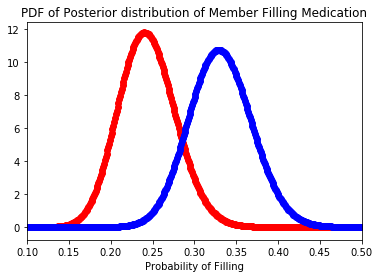

In [4]:
alpha_sa, beta_sa, alpha_sb, beta_sb = 3 + 36, 7 + 114, 3 + 50, 7 + 100
distribution_values_a = bb.beta_values(alpha=alpha_sa, beta=beta_sa)
distribution_values_b = bb.beta_values(alpha=alpha_sb, beta=beta_sb)
plt.scatter(distribution_values_a[0], distribution_values_a[1], color='red')
plt.scatter(distribution_values_b[0], distribution_values_b[1], color='blue')
plt.xlabel('Probability of Filling')
plt.title('PDF of Posterior distribution of Member Filling Medication')
plt.xlim(0.1, 0.5)
plt.show()

From the distributions plotted above, it certainly seems like B group (blue line) performed better! But notice we actually have the full distributions of the estimate of the fill rate in group A and B. In particular, with those full distributions, we are actually empowered to do a lot of things. In particular, if we wanted to calculate the probability group B is better than A, we can do so! One intuitive way is to simulate:

In [5]:
import numpy as np    
sa_samples = np.random.beta(alpha_sa, beta_sa, 100000)
sb_samples = np.random.beta(alpha_sb, beta_sb, 100000)

# Simulation Results
np.sum(sb_samples > sa_samples) / len(sa_samples)

0.95881

(Note that this implementation is also already defined in our `data_science` repo.) By default, this simply simulates 100,000 random samples from the beta distribution defined by the parameters returned above and compares the proportion of observations from sample B that are greater than sample A. In this example, sample B is about 96% "better" than sample A.

**But really why is this better than just evaluating the p-value in the frequentist world?**

Statistical Significance can at most tell us "these two things are not likely the same" (this is what rejecting the Null Hypothesis is saying). That's not really a great answer for an A/B Test. We're running this test because we want to improve fill rates. Results that say "Group B where medication adherence calls are made will probably do better" are okay, but don't you really want to know how much better? Frequentist world tells us significance, but what we're really after is **magnitude!**

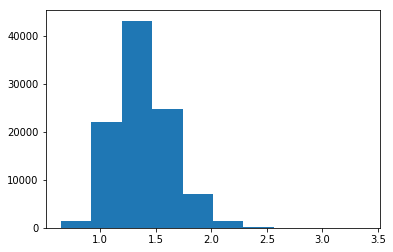

In [6]:
# Plotting the Distribution
plt.hist(sb_samples / sa_samples)
plt.show()

From this histogram we can see that our most likely cases is that B is about a 40% improvement over A, but we can see an entire range of values.

We can also plot the CDF which is also super informative

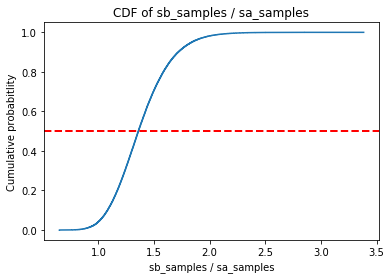

In [7]:
# Plotting the CDF 
import statsmodels.api as sm
ecdf = sm.distributions.ECDF(sb_samples / sa_samples)

x = np.linspace(min(sb_samples / sa_samples), max(sb_samples / sa_samples), 1000)
y = ecdf(x)
plt.step(x, y)
plt.ylabel("Cumulative probabitlity")
plt.xlabel("sb_samples / sa_samples")
plt.title("CDF of sb_samples / sa_samples")

plt.axhline(0.5, color='red', linestyle='dashed', linewidth=2)
plt.show()

Note the red line is drawn at the median (in this case the median improvement of B over A is about 40%).

Now we can see that there is really just a small, small chance that A is better, but even if it is better it's not going to be better by much. We can also see that there's about a 25% chance that Variant B is a 50% or more improvement over A, and even a reasonable (but quite small) chance it could be more than double the fill rate! Now in choosing B over A we can actually reason about our risk, for example, "The chance that B is 20% worse is roughly the same that it's 100% better." In short, with the full probability distribution, we can say way more nuanced things other than "we reject the null hypothesis".

## Cons of Bayesian Analysis
This is not to say that Bayesian framework is universally dominant over the Frequentist framework along every dimension (otherwise why would any A/B test evaluator use a frequentist approach ever?). Some frequently quoted cons of Bayesian analysis are:
1. **Difficulty of coming up with and defending a prior**: this is the most frequent criticism of bayesian analysis. The most common way to deal with this is to do sensitivity testing on your prior and see if your results vastly change if you alter the prior reasonably. If not, that's generally a good sign. If results are very sensitive, there's probably more work you need to do.
2. **Computationally intensive**: bayesian analysis also tends to be more computationally intensive which is probably one of the contributing reasons why they were not as frequently used in the past. Modern technology, in most cases relevant to Clover, probably has taken care of this for us.
3. **Hard to come up with an analytical solution**: goes along with number 2, but certain types of bayesian frameworks don't necessarily "converge" nicely. That being said one of the reasons for choosing the beta-binomial framework is the nice mathematical/convergence properties.

# Summary

Useful table (?) taken from https://www.dynamicyield.com/2016/09/bayesian-testing/

|Note   	|Frequentist   	|Bayesian A/B Testing   |	
|---	|---	|---	|
|Knowledge of Baseline Performance   	|Required   	|Not Required |  	
|Intuitiveness   	|Less, as p-value is a convoluted term   	|More, as we directly calculate the probability of A being better than B   |
|Sample Size   	|Pre-defined   	|No need to pre-define   	|
|Peeking at the data while the test runs    | Not allowed    | Allowed (with caution)|
|Quick to make decisions    | Less, as it has more restrictive assumptions on distributions    |More, as it has less restrictive assumptions|
|Representing uncertainty    |Confidence Interval (somewhat convoluted and frequently misunderstood)    |Highest Posterior Density Region -- highly intuitive interpretation|
|Declaring a winner    |When sample size is reached and p-value is below a certain threshold    |When either "probability to be best" goes above a threshold or the expected loss is below a threshold|

Related -- Difference between credible interval (bayesian) and confidence interval (frequentist): https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval

Some common followup questions
1. Do you need "less n" using a bayesian approach?
2. Can you "peak early" using a bayesian approach?